In [2]:
print("The start of Optimisation HW1!")

print("These are not the droids you're looking for")

The start of Optimisation HW1!
These are not the droids you're looking for


In [3]:
#Import relevant libraries

import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import random
import math

In [4]:
#Create datasets. Start with labelled examples

data_size = 500
l = int(data_size*0.1)

points_l, labels = datasets.make_blobs(n_samples=l,n_features=2, centers=2, cluster_std=5, random_state=2)

#Change 0 labels to -1

for i in range(0, len(labels)):
    if labels[i] == 0:
        labels[i] = -1

labels

array([ 1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1,  1,  1, -1,
        1, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1,  1, -1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1])

In [5]:
#Then, using information from the labelled examples, create unlabelled examples in a range

x_mean = np.mean(points_l[:,0])
y_mean = np.mean(points_l[:,1])

x_std = np.std(points_l[:,0])
y_std = np.std(points_l[:,1])

x_unlabelled = []
y_unlabelled = []
unlabelled = []

for i in range(0,data_size):
    x = random.uniform(x_mean-6*x_std, x_mean+6*x_std)
    y = random.uniform(y_mean-6*y_std, y_mean+6*y_std)

    x_unlabelled.append(x)
    y_unlabelled.append(y)
    unlabelled.append((x,y))

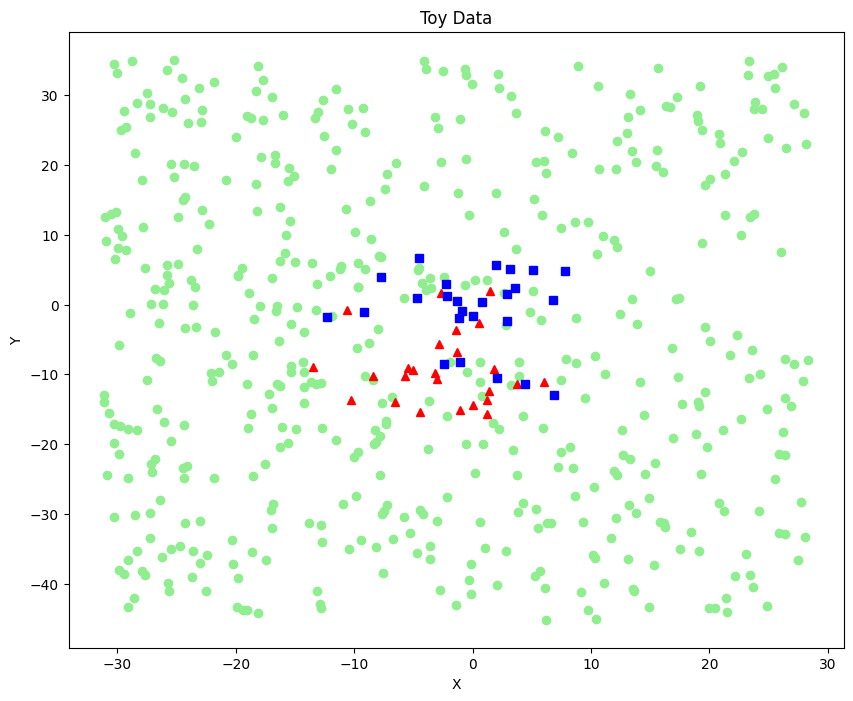

In [6]:
#Visualize

fig = plt.figure(figsize=(10,8))
plt.plot(points_l[:, 0][labels == -1], points_l[:, 1][labels == -1], 'r^')
plt.plot(points_l[:, 0][labels == 1], points_l[:, 1][labels == 1], 'bs')
plt.scatter(x_unlabelled, y_unlabelled, color='lightgreen', marker ='o')
plt.xlabel("X")
plt.ylabel("Y")
plt.title('Toy Data')
plt.show()

In [9]:
# Define weight arrays with rbf kernel

#Sigma is an optimizable parameter of RBF

sigma = 1

#Array w is the weights array between labelled examples and unlabelled examples

w_rows = []

for point in unlabelled:
    row = []
    for point2 in points_l:
        d = np.exp(-0.5*sigma*((math.dist(point, point2))**2))
        row.append(d)
    w_rows.append(row)

w = np.array(w_rows)

#Array w_ is between unlabelled.

rows = []

for points in unlabelled:
    row=[]
    for point2 in unlabelled:
        d = np.exp(-0.5*sigma*((math.dist(point, point2))**2))
        row.append(d)
    rows.append(row)

w_ = np.array(rows)

print(w.shape, w_.shape)

(500, 50) (500, 500)
